In [1]:
!pip install plot_keras_history

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 15 21:39:26 2020

@author: isswan
"""
from __future__ import print_function
import numpy as np

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight
import pandas as pd
from tensorflow. keras.preprocessing.text import Tokenizer, one_hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from plot_keras_history import plot_history


In [4]:
from sklearn.model_selection import train_test_split

<Figure size 432x288 with 0 Axes>

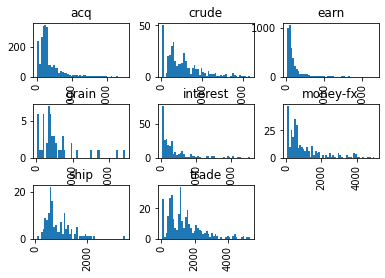

<Figure size 432x288 with 0 Axes>

In [5]:
#Data Preparation
import pandas as pd
news=pd.read_table('r8-full-data.txt',header=None,names = ["Class", "Text"])
news.head()
a = news.groupby("Class")
a.head()
a.describe()
y=news['Class']
X=news['Text']

##check the length to determine the document length for DNN

length=news['Text'].apply(len)
news=news.assign(Length=length)

#Plot the distribution of the document length for each category
import matplotlib.pyplot as plt
news.hist(column='Length',by='Class',bins=50)

plt.figure()

In [6]:
#Data Preprocessing 

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#fixed length for improved efficiency
MAX_LEN=100 
maxlen=MAX_LEN

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

vocabubary size: 19998
max length text: 964
0.848034803480348


In [7]:
#create class weight dict for unbanlanced dataset
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

c:\anaconda\envs\pyakc\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=['acq' 'crude' 'earn' 'grain' 'interest' 'money-fx' 'ship' 'trade'], y=3759    ship
2907    ship
4935    earn
1396    earn
931      acq
        ... 
905      acq
5192    earn
3980    earn
235     earn
5157    earn
Name: Class, Length: 5371, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


(2303, 8)

In [8]:
#Define the BiLSTM model with output Dropout
##############################################
model_out_dp = Sequential()
model_out_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model_out_dp.add(Bidirectional(LSTM(64)))
#output Dropout
model_out_dp.add(Dropout(0.5))
model_out_dp.add(Dense(8, activation='softmax'))

# try using different optimizers and different optimizer configs
model_out_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_out_dp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/15
5371/5371 [==============================] - 6s 1ms/sample - loss: 0.9542 - accuracy: 0.6961 - val_loss: 0.5464 - val_accuracy: 0.8037
Epoch 2/15
5371/5371 [==============================] - 2s 293us/sample - loss: 0.4986 - accuracy: 0.8302 - val_loss: 0.3959 - val_accuracy: 0.8723
Epoch 3/15
5371/5371 [==============================] - 1s 221us/sample - loss: 0.4130 - accuracy: 0.8667 - val_loss: 0.3722 - val_accuracy: 0.8645
Epoch 4/15
5371/5371 [==============================] - 1s 207us/sample - loss: 0.3477 - accuracy: 0.8907 - val_loss: 0.3243 - val_accuracy: 0.8906
Epoch 5/15
5371/5371 [==============================] - 1s 232us/sample - loss: 0.3241 - accuracy: 0.8987 - val_loss: 0.2984 - val_accuracy: 0.8997
Epoch 6/15
5371/5371 [==============================] - 1s 253us/sample - loss: 0.2765 - accuracy: 0.9112 - val_loss: 0.2892 - val_accuracy: 0.9027
Epoch 7/15
5371/5371 [==============================] - 1

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

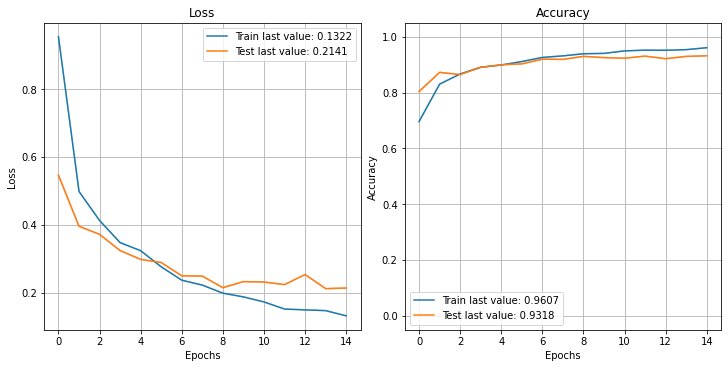

In [9]:
#Train the model
batch_size = 64

print('Train...')
hist_out_dp = model_out_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=15,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_out_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_out_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_out_dp)

In [10]:
print(hist_out_dp)

{'loss': [0.9542466957649912, 0.4985786124972342, 0.41302242890635676, 0.3477286988298135, 0.3240701368880037, 0.27654399285434544, 0.2371417657775467, 0.22270723715982188, 0.19894958762311554, 0.1879841702801403, 0.17314598314412766, 0.1521643332414311, 0.1497650356587696, 0.1475222937470041, 0.13215678665746058], 'accuracy': [0.69614595, 0.83019924, 0.86669147, 0.89070934, 0.8987153, 0.91118973, 0.9258983, 0.9314839, 0.9391175, 0.9404208, 0.9493577, 0.95196426, 0.9515919, 0.9538261, 0.96071494], 'val_loss': [0.5464210608732271, 0.395938203256388, 0.3722352062004626, 0.32431669766184457, 0.2984130024987617, 0.28924552097923073, 0.25004710936437624, 0.24914876342182102, 0.2150680031166406, 0.23298221377997982, 0.23171666898302445, 0.224220648048833, 0.25386954159437447, 0.21232810770810503, 0.21405537798353708], 'val_accuracy': [0.80373424, 0.87234044, 0.86452454, 0.8905775, 0.89969605, 0.9027356, 0.91967, 0.91880155, 0.929657, 0.9253148, 0.92314374, 0.9305254, 0.92140687, 0.929657, 0.

In [11]:
#Input Layer Dropout. 
###############################################################################
model_input_dp = Sequential()
model_input_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout
model_input_dp.add(Bidirectional(LSTM(64,dropout=0.5)))
model_input_dp.add(Dense(8, activation='softmax'))
# try using different optimizers and different optimizer configs
model_input_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_input_dp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/10
5371/5371 [==============================] - 5s 864us/sample - loss: 0.9433 - accuracy: 0.7023 - val_loss: 0.5127 - val_accuracy: 0.8281
Epoch 2/10
5371/5371 [==============================] - 1s 222us/sample - loss: 0.5484 - accuracy: 0.8142 - val_loss: 0.4340 - val_accuracy: 0.8459
Epoch 3/10
5371/5371 [==============================] - 1s 218us/sample - loss: 0.4245 - accuracy: 0.8553 - val_loss: 0.3728 - val_accuracy: 0.8676
Epoch 4/10
5371/5371 [==============================] - 1s 224us/sample - loss: 0.3681 - accuracy: 0.8775 - val_loss: 0.3181 - val_accuracy: 0.8819
Epoch 5/10
5371/5371 [==============================] - 1s 256us/sample - loss: 0.3310 - accuracy: 0.8894 - val_loss: 0.3248 - val_accuracy: 0.8901
Epoch 6/10
5371/5371 [==============================] - 1s 208us/sample - loss: 0.3024 - accuracy: 0.9036 - val_loss: 0.3619 - val_accuracy: 0.8897
Epoch 7/10
5371/5371 [==============================] -

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

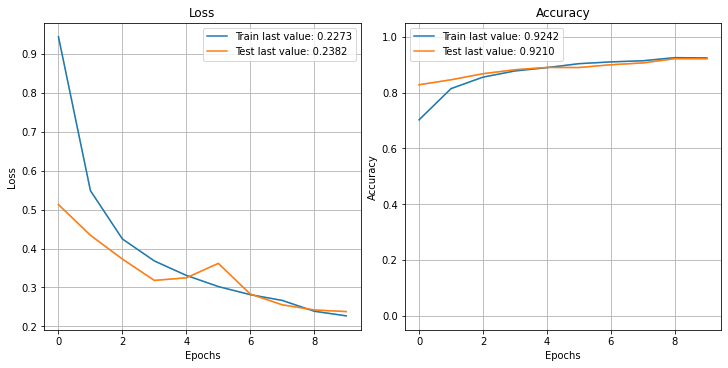

In [12]:
#Train the model
batch_size = 64

print('Train...')
hist_input_dp = model_input_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=10,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_input_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_input_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_input_dp)

In [13]:
#recurent_dropout
###############################################################################
model_rec_dp = Sequential()
model_rec_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#recurent_dropout
model_rec_dp.add(Bidirectional(LSTM(64,recurrent_dropout=0.5)))
model_rec_dp.add(Dense(8, activation='softmax'))

# try using different optimizers and different optimizer configs
model_rec_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_rec_dp.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/5
5371/5371 [==============================] - 28s 5ms/sample - loss: 1.0127 - accuracy: 0.6786 - val_loss: 0.6734 - val_accuracy: 0.7620
Epoch 2/5
5371/5371 [==============================] - 26s 5ms/sample - loss: 0.5728 - accuracy: 0.8114 - val_loss: 0.4549 - val_accuracy: 0.8506
Epoch 3/5
5371/5371 [==============================] - 25s 5ms/sample - loss: 0.4450 - accuracy: 0.8548 - val_loss: 0.3545 - val_accuracy: 0.8802
Epoch 4/5
5371/5371 [==============================] - 24s 5ms/sample - loss: 0.3657 - accuracy: 0.8790 - val_loss: 0.3237 - val_accuracy: 0.8862
Epoch 5/5
5371/5371 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.92 - 16s 3ms/sample - loss: 0.2466 - accuracy: 0.9218
Training Accuracy: 0.9218
Testing Accuracy:  0.8971


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

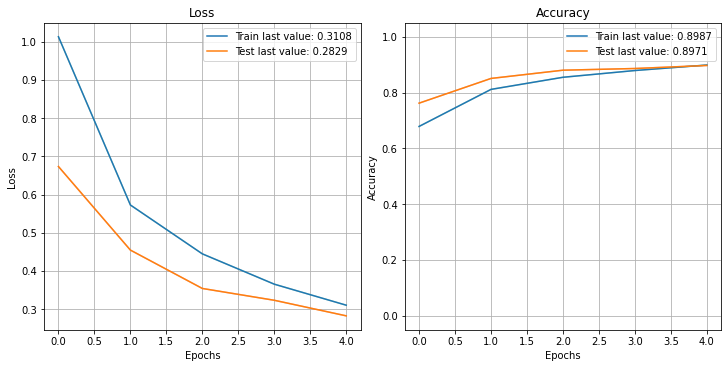

In [14]:
#Train the model
batch_size = 64

print('Train...')
hist_rec_dp = model_rec_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_rec_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_rec_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_rec_dp)

In [15]:
#Combain all dropout
##############################################################################
model_all_dp = Sequential()
model_all_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout and rec Dropout
model_all_dp.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
#output Dropout
model_all_dp.add(Dropout(0.5))
model_all_dp.add(Dense(8, activation='softmax'))
# try using different optimizers and different optimizer configs
model_all_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model_all_dp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1999800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 2,085,312
Trainable params: 85,512
Non-trainable params: 1,999,800
_________________________________________________________________


Train...
Train on 5371 samples, validate on 2303 samples
Epoch 1/12
5371/5371 [==============================] - 29s 5ms/sample - loss: 1.2257 - accuracy: 0.5943 - val_loss: 0.8130 - val_accuracy: 0.7017
Epoch 2/12
5371/5371 [==============================] - 25s 5ms/sample - loss: 0.8125 - accuracy: 0.7196 - val_loss: 0.5910 - val_accuracy: 0.7803
Epoch 3/12
5371/5371 [==============================] - 25s 5ms/sample - loss: 0.6771 - accuracy: 0.7624 - val_loss: 0.4957 - val_accuracy: 0.8241
Epoch 4/12
5371/5371 [==============================] - 25s 5ms/sample - loss: 0.6021 - accuracy: 0.7922 - val_loss: 0.4488 - val_accuracy: 0.8454
Epoch 5/12
5371/5371 [==============================] - 25s 5ms/sample - loss: 0.5611 - accuracy: 0.8060 - val_loss: 0.4142 - val_accuracy: 0.8624
Epoch 6/12
5371/5371 [==============================] - 26s 5ms/sample - loss: 0.5071 - accuracy: 0.8280 - val_loss: 0.3725 - val_accuracy: 0.8732
Epoch 7/12
5371/5371 [==============================] - 25s 5

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

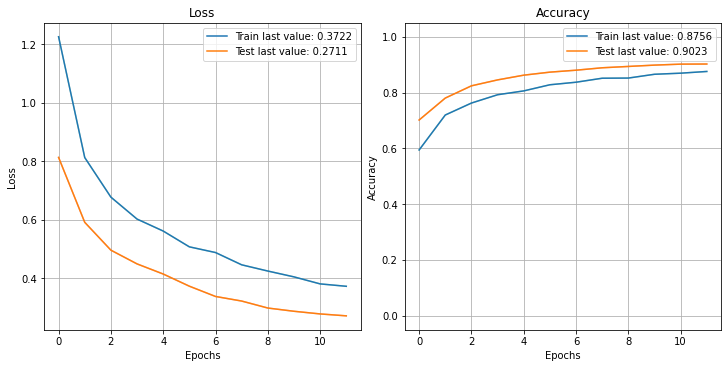

In [16]:
#Train the model
batch_size = 64

print('Train...')
hist_all_dp = model_all_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=12,
          validation_data=[X_test, y_test_onehot]).history

loss, accuracy = model_all_dp.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_all_dp.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_all_dp)

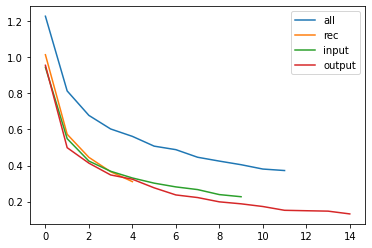

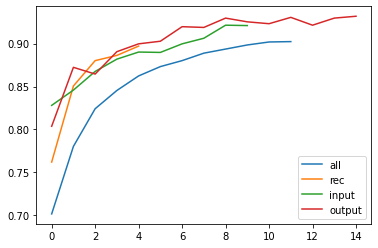

In [17]:
#Compare all the models

plt.plot(hist_all_dp['loss'], label='all')
plt.plot(hist_rec_dp['loss'], label='rec')
plt.plot(hist_input_dp['loss'], label='input')
plt.plot(hist_out_dp['loss'], label='output')
plt.legend(loc='upper right')
plt.show()

plt.plot(hist_all_dp['val_accuracy'], label='all')
plt.plot(hist_rec_dp['val_accuracy'], label='rec')
plt.plot(hist_input_dp['val_accuracy'], label='input')
plt.plot(hist_out_dp['val_accuracy'], label='output')
plt.legend(loc='lower right')
plt.show()
